In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
MAXIMUM_Q_VALUE = 0.005
ANALYSE_RECALIBRATED_FEATURES = False

for one of the runs, for each sequence-charge, find...
- sequence identified
- theoretical mass
- measured mass of feature before recalibration
- mass error before recalibration
- measured mass of feature after recalibration
- mass error after recalibration

In [15]:
EXPERIMENT_NAME = 'YHE'
EXPERIMENT_BASE_DIR = '/data/experiments/{}'.format(EXPERIMENT_NAME)

# percolator output files
PERCOLATOR_OUTPUT_FILE = '{}/percolator-output/{}.percolator.target.psms.txt'.format(EXPERIMENT_BASE_DIR, EXPERIMENT_NAME)
PERCOLATOR_RECALIBRATED_OUTPUT_FILE = '{}/recalibrated-percolator-output/{}.percolator.target.psms.txt'.format(EXPERIMENT_BASE_DIR, EXPERIMENT_NAME)

# percolator stdout files
PERCOLATOR_STDOUT_FILE = '{}/percolator-output/percolator-stdout.log'.format(EXPERIMENT_BASE_DIR)
PERCOLATOR_RECALIBRATED_STDOUT_FILE = '{}/recalibrated-percolator-output/recalibrated-percolator-stdout.log'.format(EXPERIMENT_BASE_DIR)


In [16]:
# determine the mapping between the percolator index and the run file name - this is only
# available by parsing percolator's stdout redirected to a text file.
def find_percolator_file_mapping(percolator_stdout_file_name):
    mapping = []
    with open(percolator_stdout_file_name) as f:
        lines = f.readlines()
        for line in lines:
            if line.startswith('INFO: Assigning index'):
                splits = line.split(' ')
                percolator_index = int(splits[3])
                comet_filename = splits[5]
                run_name = comet_filename.split('/')[-1].split('.')[0]  # e.g. 190719_Hela_Ecoli_1to3_06
                mapping.append((percolator_index, run_name))
    mapping_df = pd.DataFrame(mapping, columns=['percolator_idx','run_name'])
    return mapping_df

In [17]:
before_recal_mapping_df = find_percolator_file_mapping(PERCOLATOR_STDOUT_FILE)
after_recal_mapping_df = find_percolator_file_mapping(PERCOLATOR_RECALIBRATED_STDOUT_FILE)

In [18]:
before_recal_file_idx_for_analysis = 5

In [19]:
before_mapping_df = pd.read_csv('{}/percolator-output/percolator-idx-mapping.csv'.format(EXPERIMENT_BASE_DIR))
after_mapping_df = pd.read_csv('{}/recalibrated-percolator-output/percolator-idx-mapping.csv'.format(EXPERIMENT_BASE_DIR))

In [20]:
before_mapping_df.columns

Index(['percolator_idx', 'run_name'], dtype='object')

In [21]:
after_mapping_df.columns

Index(['file_idx', 'run_name'], dtype='object')

In [22]:
percolator_index_run_name = before_mapping_df[before_mapping_df.percolator_idx == before_recal_file_idx_for_analysis].iloc[0].run_name
percolator_index_run_name

'YHE211_05_Slot1-1_1_3001'

In [23]:
after_recal_file_idx_for_analysis = after_mapping_df[after_mapping_df.run_name == percolator_index_run_name].iloc[0].file_idx
after_recal_file_idx_for_analysis

11

In [24]:
before_recal_psms_df = pd.read_csv(PERCOLATOR_OUTPUT_FILE, sep='\t')
before_recal_psms_df = before_recal_psms_df[before_recal_psms_df['percolator q-value'] <= MAXIMUM_Q_VALUE]
before_recal_psms_df = before_recal_psms_df[before_recal_psms_df.file_idx == before_recal_file_idx_for_analysis]

In [25]:
after_recal_psms_df = pd.read_csv(PERCOLATOR_RECALIBRATED_OUTPUT_FILE, sep='\t')
after_recal_psms_df = after_recal_psms_df[after_recal_psms_df['percolator q-value'] <= MAXIMUM_Q_VALUE]
after_recal_psms_df = after_recal_psms_df[after_recal_psms_df.file_idx == after_recal_file_idx_for_analysis]

In [26]:
len(before_recal_psms_df.sequence.unique()), len(after_recal_psms_df.sequence.unique())

(10733, 9084)

In [30]:
before_recal_features_file_name = '{}/features/exp-{}-run-{}-features-precursor-*.pkl'.format(EXPERIMENT_BASE_DIR, EXPERIMENT_NAME, percolator_index_run_name)
after_recal_features_file_name = '{}/recalibrated-features/{}/{}-recalibrated-features-all.pkl'.format(EXPERIMENT_BASE_DIR, percolator_index_run_name, percolator_index_run_name)

In [31]:
before_recal_features_file_name, after_recal_features_file_name

('/data/experiments/YHE/features/YHE211_05_Slot1-1_1_3001/YHE211_05_Slot1-1_1_3001-features-all.pkl',
 '/data/experiments/YHE/recalibrated-features/YHE211_05_Slot1-1_1_3001/YHE211_05_Slot1-1_1_3001-recalibrated-features-all.pkl')

In [32]:
before_recal_features_df = pd.read_pickle(before_recal_features_file_name)


FileNotFoundError: [Errno 2] No such file or directory: '/data/experiments/YHE/features/YHE211_05_Slot1-1_1_3001/YHE211_05_Slot1-1_1_3001-features-all.pkl'

In [20]:
before_recal_features_df.head()

,monoisotopic_mz,charge,intensity,intensity_full_rt_extent,scan_apex,scan_lower,scan_upper,rt_apex,rt_lower,rt_upper,precursor_id,feature_id,monoisotopic_mass
0,598.308236,2,17438.000000,23946,785.76,728.13,843.40,964.66,947.57,981.75,63406,6340601,1194.601871
1,597.315838,2,14208.000000,29188,775.71,737.99,813.43,961.83,945.02,978.64,63406,6340602,1192.617076
0,648.831986,2,129448.000000,142548,633.69,619.83,647.54,362.69,354.18,371.20,13382,1338201,1295.649372
1,647.292052,2,86186.166207,26759,665.28,637.20,693.37,362.34,359.88,364.81,13382,1338202,1292.569503
2,650.338742,2,25593.000000,58430,650.37,595.00,670.00,365.93,353.45,373.45,13382,1338203,1298.662883


In [21]:
after_recal_features_df = pd.read_pickle(after_recal_features_file_name)


In [22]:
after_recal_features_df.tail()

,feature_id,charge,rt_apex,rt_peak_width,scan_apex,scan_peak_width,intensity,precursor_id,monoisotopic_mass,predicted_mass_error,recalibrated_monoisotopic_mass,recalibrated_monoisotopic_mz
3,1560404,2,397.96,25.87,836.86,106.89,31003.0,15604,1194.613863,-0.004235,1194.618098,598.316325
4,1560405,2,392.77,7.42,818.37,33.79,10662.0,15604,1193.471184,-0.002240,1193.473424,597.743988
0,1617701,2,402.60,6.65,94.69,50.27,186356.0,16177,2333.010841,0.003401,2333.007440,1167.510996
0,3982401,2,687.74,8.92,533.53,29.33,759358.0,39824,1533.706140,-0.004028,1533.710168,767.862360
1,3982402,3,679.82,23.80,534.85,75.00,67155.0,39824,2303.057153,-0.003566,2303.060718,768.694182


In [23]:
# merge the features for this file so we get the feature underlying the sequence identification
combined_psms_df = pd.merge(before_recal_psms_df, before_recal_features_df, how='left', left_on=['scan'], right_on=['feature_id'], suffixes=('_psms','_before'))
combined_psms_df = pd.merge(combined_psms_df, after_recal_features_df, how='left', left_on=['scan'], right_on=['feature_id'], suffixes=('_psms','_after'))

In [24]:
combined_psms_df.columns

Index(['file_idx', 'scan', 'charge_psms', 'spectrum precursor m/z',
       'spectrum neutral mass', 'peptide mass', 'percolator score',
       'percolator q-value', 'percolator PEP', 'total matches/spectrum',
       'sequence', 'protein id', 'flanking aa', 'monoisotopic_mz',
       'charge_before', 'intensity_psms', 'intensity_full_rt_extent',
       'scan_apex_psms', 'scan_lower', 'scan_upper', 'rt_apex_psms',
       'rt_lower', 'rt_upper', 'precursor_id_psms', 'feature_id_psms',
       'monoisotopic_mass_psms', 'feature_id_after', 'charge', 'rt_apex_after',
       'rt_peak_width', 'scan_apex_after', 'scan_peak_width',
       'intensity_after', 'precursor_id_after', 'monoisotopic_mass_after',
       'predicted_mass_error', 'recalibrated_monoisotopic_mass',
       'recalibrated_monoisotopic_mz'],
      dtype='object')

In [25]:
PROTON_MASS = 1.007276
ADD_C_CYSTEINE_DA = 57.021464

In [26]:
identifications_df = pd.DataFrame()
identifications_df['sequence'] = combined_psms_df.sequence
identifications_df['theoretical_mass'] = combined_psms_df['peptide mass'] + (combined_psms_df.sequence.str.count('C') * ADD_C_CYSTEINE_DA)
identifications_df['measured_mass_before_recal'] = (combined_psms_df.monoisotopic_mz * combined_psms_df.charge_before) - (PROTON_MASS * combined_psms_df.charge_before)
identifications_df['measured_mass_after_recal'] = combined_psms_df.recalibrated_monoisotopic_mass
identifications_df['feature_mono_mz_before_recal'] = combined_psms_df.monoisotopic_mz
identifications_df['feature_mono_mz_after_recal'] = combined_psms_df.recalibrated_monoisotopic_mz
identifications_df['mass_accuracy_ppm_before_recal'] = ((identifications_df.measured_mass_before_recal - identifications_df.theoretical_mass) / identifications_df.theoretical_mass) * 10**6
identifications_df['mass_accuracy_ppm_after_recal'] = ((identifications_df.measured_mass_after_recal - identifications_df.theoretical_mass) / identifications_df.theoretical_mass) * 10**6
identifications_df['rt_apex'] = combined_psms_df.rt_apex_after
identifications_df['scan_apex'] = combined_psms_df.scan_apex_after
identifications_df['intensity'] = combined_psms_df.intensity_after

In [27]:
identifications_df = identifications_df[(identifications_df.mass_accuracy_ppm_before_recal >= -10) & (identifications_df.mass_accuracy_ppm_before_recal <= 10)]
identifications_df = identifications_df[(identifications_df.mass_accuracy_ppm_after_recal >= -10) & (identifications_df.mass_accuracy_ppm_after_recal <= 10)]

In [28]:
identifications_df.head()

,sequence,theoretical_mass,measured_mass_before_recal,measured_mass_after_recal,feature_mono_mz_before_recal,feature_mono_mz_after_recal,mass_accuracy_ppm_before_recal,mass_accuracy_ppm_after_recal,rt_apex,scan_apex,intensity
0,EAESCDCLQGFQLTHSLGGGTGSGMGTLLISK,3310.526728,3310.530832,3310.527011,1104.517553,1104.516280,1.239798,0.085359,874.74,360.32,6729462.0
1,AEEHISSSHGDVDYAQASAELAK,2414.098600,2414.097917,2414.098756,805.706582,805.706861,-0.282788,0.064615,438.88,678.88,711054.0
2,FCGAEGLNNVITLSTFR,1897.935564,1897.934836,1897.935502,949.974694,949.975027,-0.383747,-0.032843,917.22,320.77,1829855.0
3,EAESCDCLQGFQLTHSLGGGTGSGMGTLLISK,3310.526728,3310.530966,3310.527023,1104.517598,1104.516284,1.280009,0.089162,874.75,361.52,3092581.0
4,FCGAEGLNNVITLSTFR,1897.935564,1897.934770,1897.935276,949.974661,949.974914,-0.418225,-0.151859,917.22,321.13,1425813.0


In [29]:
identifications_df[(identifications_df.sequence == 'IFVGNVSAACTSQELR')]

,sequence,theoretical_mass,measured_mass_before_recal,measured_mass_after_recal,feature_mono_mz_before_recal,feature_mono_mz_after_recal,mass_accuracy_ppm_before_recal,mass_accuracy_ppm_after_recal,rt_apex,scan_apex,intensity
8619,IFVGNVSAACTSQELR,1750.867164,1750.862992,1750.866749,876.438772,876.44065,-2.382808,-0.237109,617.95,371.07,325122.0


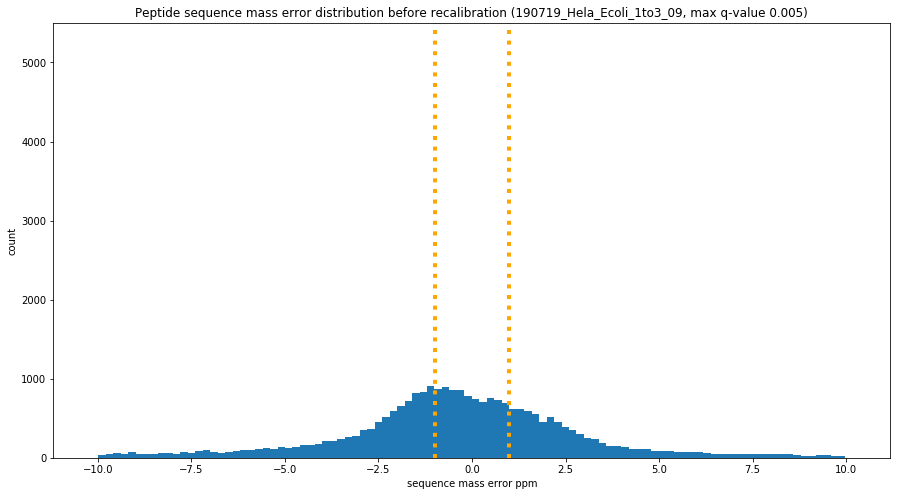

In [30]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('Peptide sequence mass error distribution before recalibration ({}, max q-value {})'.format(percolator_index_run_name, MAXIMUM_Q_VALUE))

bins = 100
hist, bins, _ = plt.hist(identifications_df.mass_accuracy_ppm_before_recal, bins=bins)
plt.xlabel('sequence mass error ppm')
plt.ylabel('count')

plt.ylim((0,5500))

plt.axvline(x=+1, linestyle=':', linewidth=4, color='orange')
plt.axvline(x=-1, linestyle=':', linewidth=4, color='orange')

plt.show()

In [31]:
print("{} have mass error less than 1 ppm".format(len(identifications_df[identifications_df.mass_accuracy_ppm_before_recal.abs() < 1]) / len(identifications_df)))

0.30800234787712777 have mass error less than 1 ppm


In [32]:
print("{} have mass error less than 1 ppm".format(len(identifications_df[identifications_df.mass_accuracy_ppm_after_recal.abs() < 1]) / len(identifications_df)))

0.8307571903737038 have mass error less than 1 ppm


In [46]:
print("{} have mass error less than 500 ppb".format(len(identifications_df[identifications_df.mass_accuracy_ppm_after_recal.abs() < 0.5]) / len(identifications_df)))

0.6867931911563295 have mass error less than 500 ppb


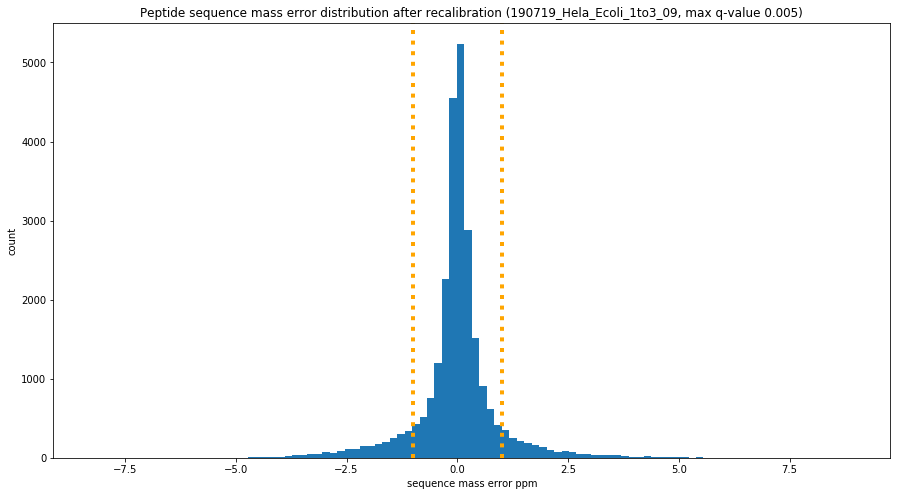

In [33]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('Peptide sequence mass error distribution after recalibration ({}, max q-value {})'.format(percolator_index_run_name, MAXIMUM_Q_VALUE))

bins = 100
hist, bins, _ = plt.hist(identifications_df.mass_accuracy_ppm_after_recal, bins=bins)
plt.xlabel('sequence mass error ppm')
plt.ylabel('count')

plt.ylim((0,5500))

plt.axvline(x=+1, linestyle=':', linewidth=4, color='orange')
plt.axvline(x=-1, linestyle=':', linewidth=4, color='orange')

plt.show()

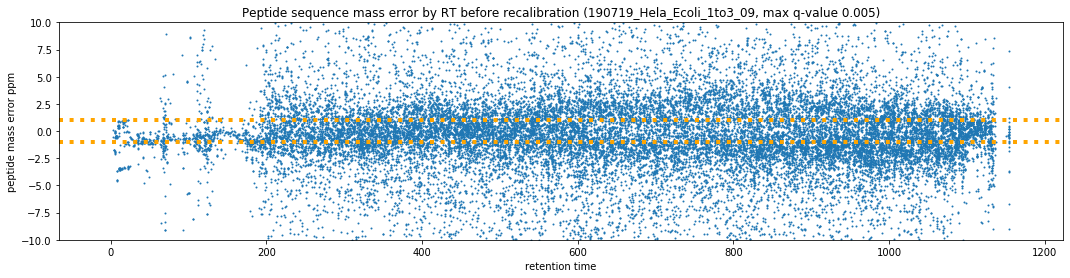

In [40]:
f, ax = plt.subplots()
f.set_figheight(4)
f.set_figwidth(18)

plt.margins(0.06)
plt.title('Peptide sequence mass error by RT before recalibration ({}, max q-value {})'.format(percolator_index_run_name,MAXIMUM_Q_VALUE))

ax.scatter(identifications_df.rt_apex, identifications_df.mass_accuracy_ppm_before_recal, marker='o', lw=0, s=4, alpha=1.0)

plt.ylabel('peptide mass error ppm')
plt.xlabel('retention time')
# plt.xlim((300,400))
plt.ylim((-10,+10))

plt.axhline(y=+1, linestyle=':', linewidth=4, color='orange')
plt.axhline(y=-1, linestyle=':', linewidth=4, color='orange')

plt.show()

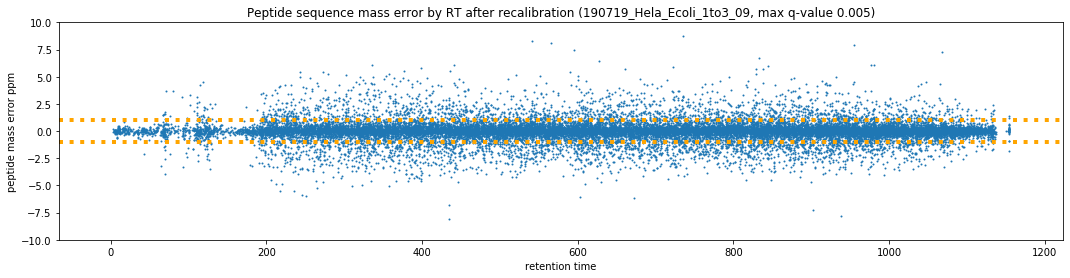

In [41]:
f, ax = plt.subplots()
f.set_figheight(4)
f.set_figwidth(18)

plt.margins(0.06)
plt.title('Peptide sequence mass error by RT after recalibration ({}, max q-value {})'.format(percolator_index_run_name,MAXIMUM_Q_VALUE))

ax.scatter(identifications_df.rt_apex, identifications_df.mass_accuracy_ppm_after_recal, marker='o', lw=0, s=4, alpha=1.0)

plt.ylabel('peptide mass error ppm')
plt.xlabel('retention time')
# plt.xlim((300,400))
plt.ylim((-10,+10))

plt.axhline(y=+1, linestyle=':', linewidth=4, color='orange')
plt.axhline(y=-1, linestyle=':', linewidth=4, color='orange')

plt.show()

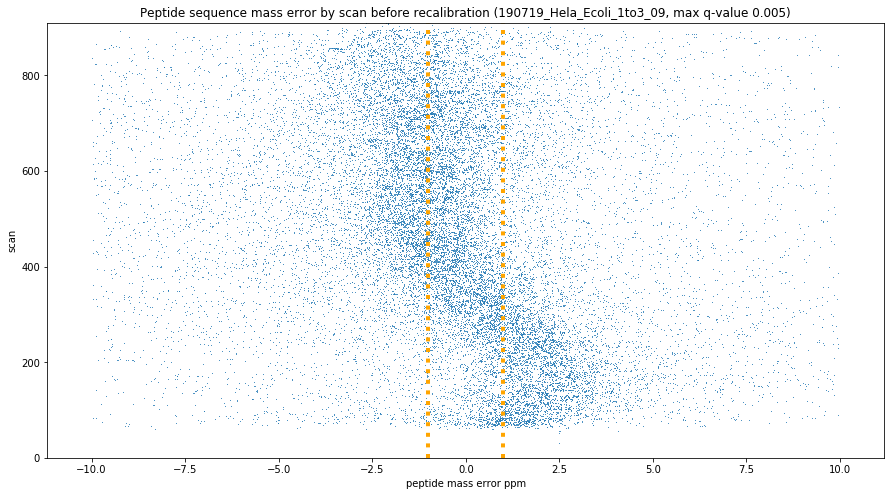

In [44]:
f, ax = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('Peptide sequence mass error by scan before recalibration ({}, max q-value {})'.format(percolator_index_run_name,MAXIMUM_Q_VALUE))

ax.scatter(identifications_df.mass_accuracy_ppm_before_recal, identifications_df.scan_apex, marker='o', lw=0, s=1, alpha=1.0)

plt.xlabel('peptide mass error ppm')
plt.ylabel('scan')
plt.ylim((0,910))

plt.axvline(x=+1, linestyle=':', linewidth=4, color='orange')
plt.axvline(x=-1, linestyle=':', linewidth=4, color='orange')

plt.show()

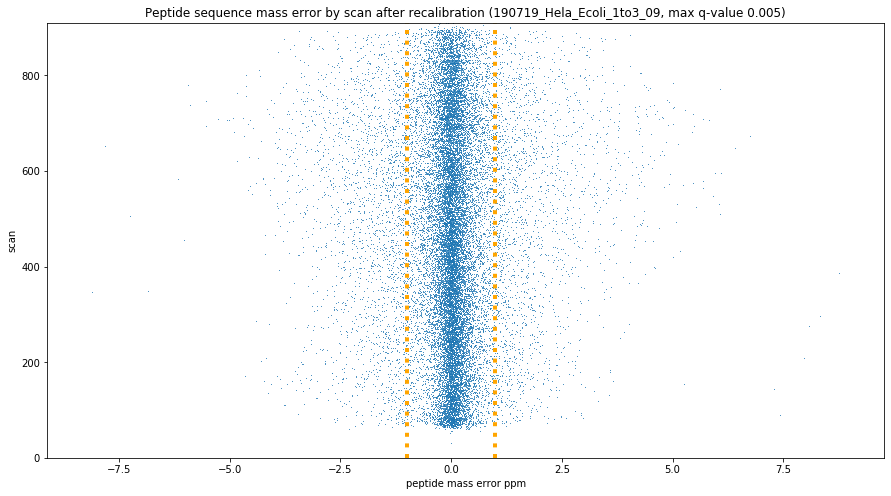

In [45]:
f, ax = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('Peptide sequence mass error by scan after recalibration ({}, max q-value {})'.format(percolator_index_run_name,MAXIMUM_Q_VALUE))

ax.scatter(identifications_df.mass_accuracy_ppm_after_recal, identifications_df.scan_apex, marker='o', lw=0, s=1, alpha=1.0)

plt.xlabel('peptide mass error ppm')
plt.ylabel('scan')
plt.ylim((0,910))

plt.axvline(x=+1, linestyle=':', linewidth=4, color='orange')
plt.axvline(x=-1, linestyle=':', linewidth=4, color='orange')

plt.show()

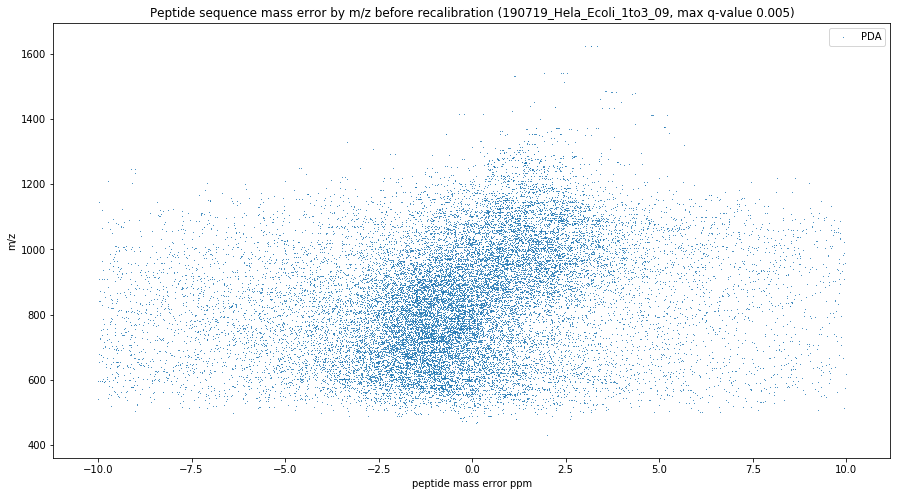

In [81]:
f, ax = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('Peptide sequence mass error by m/z before recalibration ({}, max q-value {})'.format(percolator_index_run_name,MAXIMUM_Q_VALUE))

ax.scatter(identifications_df.mass_accuracy_ppm_before_recal, identifications_df.feature_mono_mz_before_recal, marker='o', lw=0, s=1, alpha=1.0, label="PDA")

plt.legend(loc='best')
plt.xlabel('peptide mass error ppm')
plt.ylabel('m/z')

plt.show()

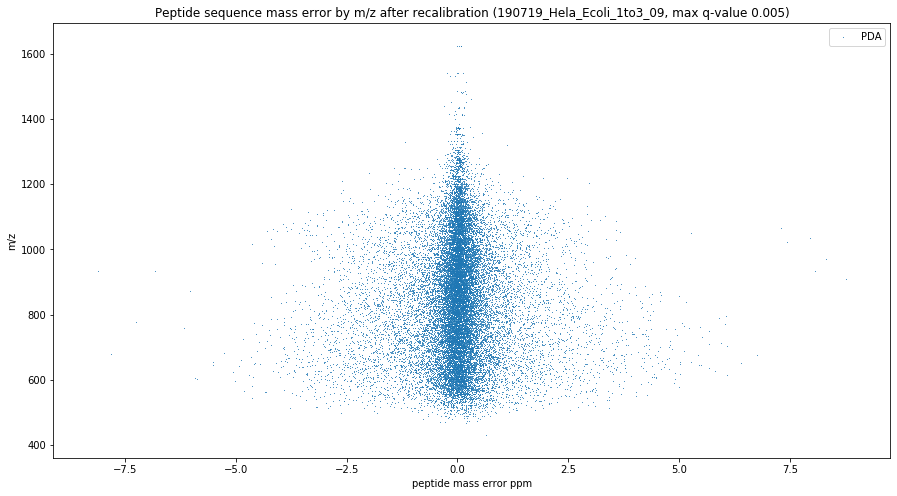

In [82]:
f, ax = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('Peptide sequence mass error by m/z after recalibration ({}, max q-value {})'.format(percolator_index_run_name,MAXIMUM_Q_VALUE))

ax.scatter(identifications_df.mass_accuracy_ppm_after_recal, identifications_df.feature_mono_mz_after_recal, marker='o', lw=0, s=1, alpha=1.0, label="PDA")

plt.legend(loc='best')
plt.xlabel('peptide mass error ppm')
plt.ylabel('m/z')

plt.show()

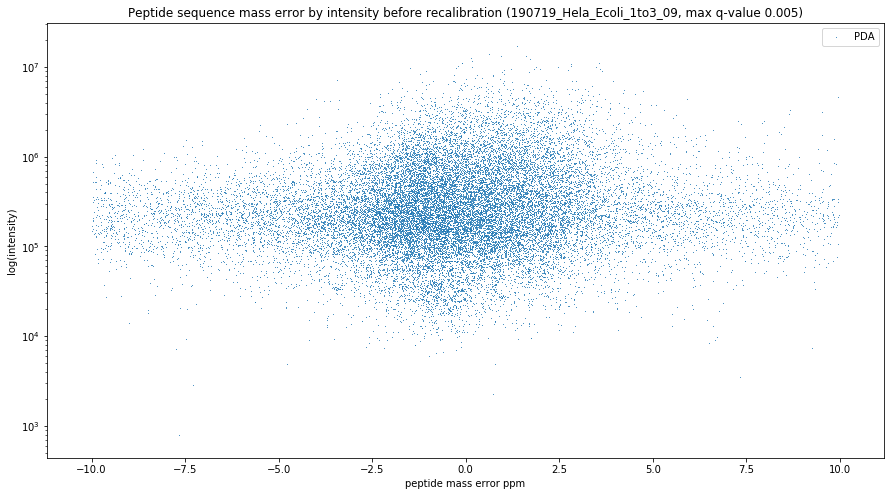

In [83]:
f, ax = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('Peptide sequence mass error by intensity before recalibration ({}, max q-value {})'.format(percolator_index_run_name,MAXIMUM_Q_VALUE))

ax.scatter(identifications_df.mass_accuracy_ppm_before_recal, identifications_df.intensity, marker='o', lw=0, s=1, alpha=1.0, label="PDA")

plt.legend(loc='best')
plt.xlabel('peptide mass error ppm')
plt.ylabel('log(intensity)')
ax.set_yscale('log')

plt.show()

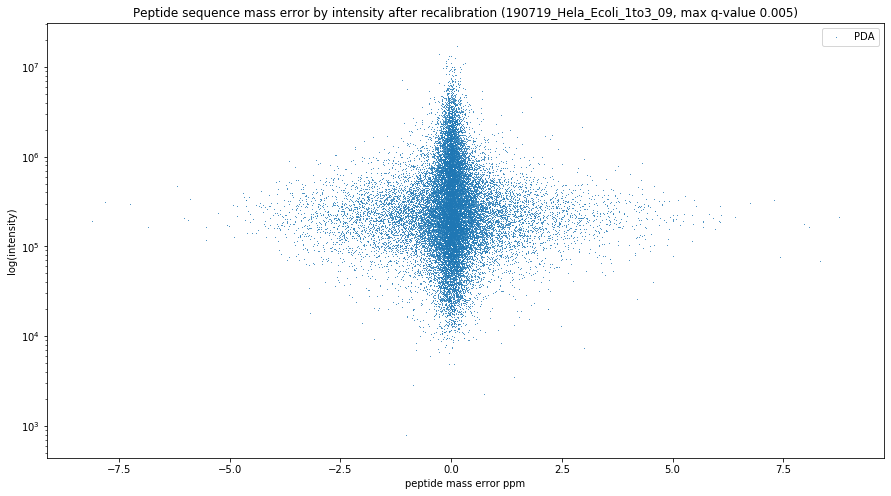

In [84]:
f, ax = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('Peptide sequence mass error by intensity after recalibration ({}, max q-value {})'.format(percolator_index_run_name,MAXIMUM_Q_VALUE))

ax.scatter(identifications_df.mass_accuracy_ppm_after_recal, identifications_df.intensity, marker='o', lw=0, s=1, alpha=1.0, label="PDA")

plt.legend(loc='best')
plt.xlabel('peptide mass error ppm')
plt.ylabel('log(intensity)')
ax.set_yscale('log')

plt.show()